- 색을 자동으로 칠해주는 인공지능
  - Let There be color 모델
- LAB 색 체계
  - L : 명도
  - A,B : 채널과 색을나타내는데 A,B 채널로 이루어짐  
- Let There be color 모델
  - raw lebel 특징 추출기 : 이미지의 raw level 특징 추출
  - global lebel 특징 추출기 : 이미지의 전체적인 특징
  - middle lebel 특징 추출기 : 중간크기의 측징 추출
  - 컬러라이제이션 신경망 : 특징으로부터 색을 학습

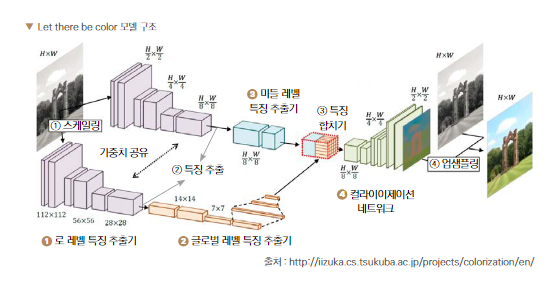

In [6]:
# 데이터 살펴보기
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# 압축해제
!unzip '/content/drive/MyDrive/자동채색/자동채색.zip'

In [8]:
imgs = glob.glob('/content/Images/*.jpg')

In [9]:
imgs[:3]

['/content/Images/1999444757_1b92efb590.jpg',
 '/content/Images/2822290399_97c809d43b.jpg',
 '/content/Images/440190907_bf8b7ba8ef.jpg']

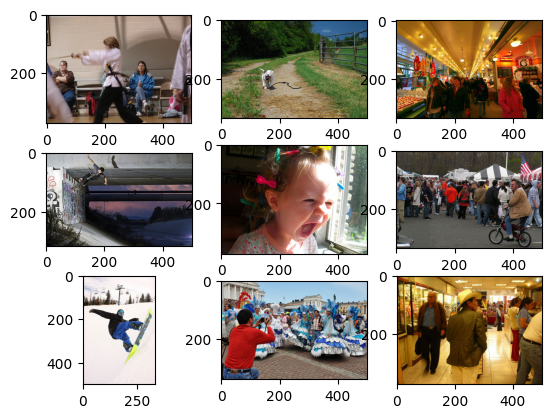

In [10]:
# 이미지를 3x3 출력
for i in range(9):
  img = Image.open(imgs[i])
  plt.subplot(3,3,i+1)
  plt.imshow(img)
plt.show()

In [11]:
# RGB -> LAB : openCV
import cv2

In [12]:
import numpy as np
from torch.utils.data.dataset import Dataset

In [13]:
def rgb2lab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
def lab2rgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [14]:
# 데이터셋
class AutoColoring(Dataset):
  def __init__(self):
    self.data = glob.glob('/content/Images/*.jpg')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    rgb = np.array(Image.open( self.data[index] ).resize((256,256)))
    lab = rgb2lab(rgb)
    # 채널 차원이 가장 앞에 오도록 변경  (256,256,3) - >(3,256,256)
    # 파이토치에서는 이미지를 표현할때 채널 차원이 가장 앞에 나와야 하므로
    lab =  lab.transpose( (2,0,1) ).astype(np.float32)
    # 모델 입력데이터가 흑백이미지 이므로 L채널이 입력 ,색을 표현하는 AB채널이 정답
    return lab[0], lab[1:]

In [15]:
# law model : 작은 크기의 특징을 추출
# 합성곱, 배치정규화, 활성화
# 기울기소실문제로 대략 6번만 반복

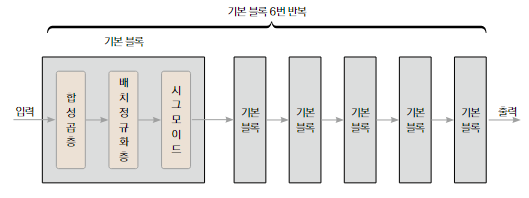

In [16]:
import torch
import torch.nn as nn

In [17]:
class LawLabel(nn.Module):
  def __init__(self) -> None:
    super(LawLabel,self).__init__()
    self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=2,padding=1)
    self.bat1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.bat3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.bat4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1)
    self.bat5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.bat6 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    x = self.sigmoid(self.bat3(self.conv3(x)))
    x = self.sigmoid(self.bat4(self.conv4(x)))
    x = self.sigmoid(self.bat5(self.conv5(x)))
    x = self.sigmoid(self.bat6(self.conv6(x)))
    return x

In [18]:
# 미들 레벨
# 이미지 크기 변환 없이 특징 추출 스트라이드, 페딩 전부 1
# 기본 블럭 2번 반복

In [19]:
class MiddleLabel(nn.Module):
  def __init__(self) -> None:
    super(MiddleLabel,self).__init__()
    self.conv1 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(256)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    return x

In [20]:
# 글로벌 레벨 특징 추출기 : 4번 반복
# MLP 층 이용-> 나중에  색을 칠할때 특징을 추출하려는 용도
class GlobalLabel(nn.Module):
  def __init__(self) -> None:
    super(GlobalLabel,self).__init__()
    self.conv1 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.bat1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(512)
    self.conv3 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.bat3 = nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat4 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()

    # MLP 특징추출용도의 분류기가 아니라
    # 색을 칙할 목적을 위해  사용
    self.fc1 = nn.Linear(32768, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)

  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    x = self.sigmoid(self.bat3(self.conv3(x)))
    x = self.sigmoid(self.bat4(self.conv4(x)))

    # 1차원으로 펼치기
    x = torch.flatten(x,start_dim=1)   # 0은 배치크기를 나타내므로 실제 사이즈는 1부터
    x = self.sigmoid( self.fc1(x) )
    x = self.sigmoid( self.fc2(x) )
    x = self.sigmoid( self.fc3(x) )
    return x

In [21]:
# 컬러라이제이션 신경망
# 합성곱 대신에 업셈플링을 사용 - 픽셀값을 직접나타내기 때문에 배치 정규화나 활성화 함수가 없다
# 출력값이 변경되면 픽셀값의 정보가 소실되기때문

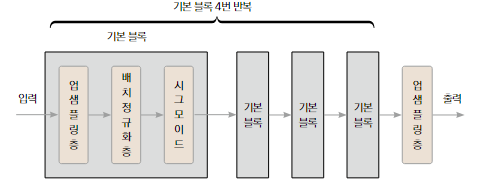

In [22]:
# 특징추출기로부터 받은 특성을 이용해서 색을 칠함
class Colorization(nn.Module):
  def __init__(self) -> None:
    super(Colorization,self).__init__()
    self.color1 = nn.ConvTranspose2d(256,128,kernel_size=3,stride=1,padding=1)
    self.bat1 = nn.BatchNorm2d(128)
    self.color2 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2,padding=0)
    self.bat2 = nn.BatchNorm2d(64)
    self.color3 = nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1)
    self.bat3 = nn.BatchNorm2d(64)
    self.color4 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2,padding=0)
    self.bat4 = nn.BatchNorm2d(32)
    self.color5 = nn.ConvTranspose2d(32,2,kernel_size=2,stride=2,padding=0)

    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.sigmoid(self.bat1(self.color1(x)))
    x = self.sigmoid(self.bat2(self.color2(x)))
    x = self.sigmoid(self.bat3(self.color3(x)))
    x = self.sigmoid(self.bat4(self.color4(x)))
    x = self.color5(x)

    return x

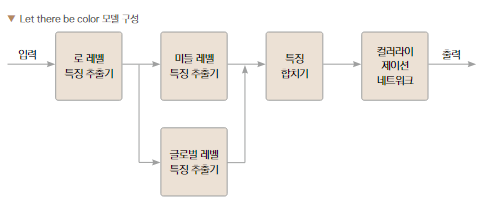

In [23]:
# 자동 채색 모델
class AutoColoringModel(nn.Module):
  def __init__(self) -> None:
    super(AutoColoringModel,self).__init__()
    # 로 레벨 특징 추출기
    self.law = LawLabel()
    self.mid = MiddleLabel()
    self.glob =GlobalLabel()
    # 특징 합치기
    self.fusion = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    # 색입히기
    self.color = Colorization()
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.law(x)
    mid = self.mid(x)
    glob = self.glob(x)
    # 글로벌 레벨 특징 추출기의 출력을 미들 레벨의 특징 추출기의 출력크기를 맞추도록 반복
    fusion = glob.repeat(1,mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(fusion, (-1,256,mid.shape[2],mid.shape[2]))
    # 결합
    fusion = torch.cat([mid,fusion],dim=1)
    fusion = self.fusion(fusion)
    fusion = self.sigmoid(fusion)
    # 신경망
    color = self.color(fusion)
    return color

In [24]:
# 모델 학습
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoColoringModel().to(device)
dataset = AutoColoring()
loader = DataLoader(dataset,batch_size=32,shuffle=True)
optim = Adam(model.parameters())

In [27]:
# 200번 정도 수행해야함
for epoch in range(5):
  iter = tqdm.tqdm(loader)
  for L ,AB in iter:
    # L 채널은 흑백이므로 채널차원을 확보
    L = torch.unsqueeze(L,dim=1).to(device)
    optim.zero_grad()
    pred = model(L)
    loss = nn.MSELoss()(pred, AB.to(device))
    loss.backward()
    optim.step()
    iter.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),'AutoColor.pth')

epoch:4 loss:8154.9541015625: 100%|██████████| 253/253 [02:40<00:00,  1.58it/s]


(256, 256)
(1, 256, 256) (2, 256, 256)
(3, 256, 256)


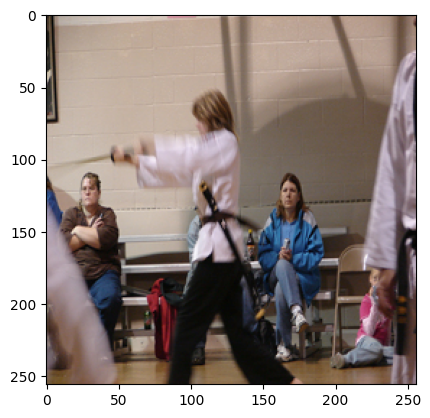

In [33]:
test_L, test_AB =  dataset[0]
print(test_L.shape)
# pyplot 형태로 변형
test_L = np.expand_dims(test_L, axis=0)
print(test_L.shape,test_AB.shape)
real_img = np.concatenate([test_L, test_AB])
print(real_img.shape)
# 그리기 위해서 채널 정보를 뒤로 배치
real_img = real_img.transpose(1,2,0).astype(np.uint8)
# LAB -> RGB
real_img = lab2rgb(real_img)
plt.imshow(real_img)

test_L shape : (1, 256, 256)


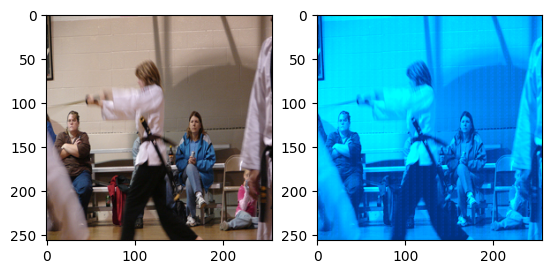

In [41]:
# 모델 예측결과
with torch.no_grad():
  model.load_state_dict(
      torch.load("AutoColor.pth",map_location=device)
  )
  # 예측값 계산
  print(f'test_L shape : {test_L.shape}')
  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)
  pred_AB = model(input_tensor)

  # 출력을 위해서 이미지형식 변경하기
  pred_LAB =  torch.cat([input_tensor,pred_AB ], dim=1)
  pred_LAB =  torch.squeeze(pred_LAB)
  pred_LAB =  pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

# 정답과 예측
plt.subplot(1,2,1)
plt.imshow(real_img)

plt.subplot(1,2,2)
plt.imshow(pred_LAB)

plt.show()



In [48]:
test_path = '/content/test.jpg'
rgb = np.array(Image.open( test_path ).resize((256,256)))
print(rgb.shape)
lab = rgb2lab(rgb)
lab =  lab.transpose( (2,0,1) ).astype(np.float32)
print(lab[0].shape)
lab = lab[0]
lab_L = np.expand_dims(lab, axis=0)
print(lab_L.shape)

(256, 256, 3)
(256, 256)
(1, 256, 256)


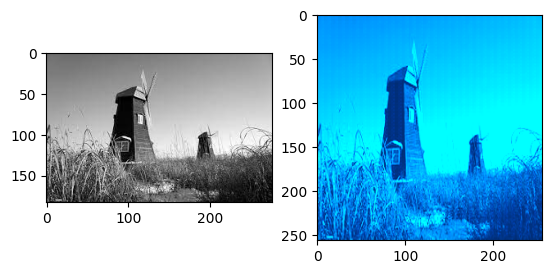

In [52]:
# 모델 예측결과
with torch.no_grad():
  model.load_state_dict(
      torch.load("AutoColor.pth",map_location=device)
  )
  # 예측값 계산
  input_tensor = torch.tensor(lab_L)
  input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)
  pred_AB = model(input_tensor)

  # 출력을 위해서 이미지형식 변경하기
  pred_LAB =  torch.cat([input_tensor,pred_AB ], dim=1)
  pred_LAB =  torch.squeeze(pred_LAB)
  pred_LAB =  pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))


# 정답과 예측
plt.subplot(1,2,1)
real_img = Image.open('/content/test.jpg')
plt.imshow(real_img)

plt.subplot(1,2,2)
plt.imshow(pred_LAB)

plt.show()
